# Predicting Powerful tweets: classifying tweets from politicians and citizens.

### Load packages

In [212]:
import pandas as pd
import json
import numpy as np
import re
import os

from langchain_openai import ChatOpenAI  # Updated import for ChatOpenAI
from langchain.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate

# Initialize the chat-based model

from sentence_transformers import SentenceTransformer

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

from sklearn.model_selection import GridSearchCV

from bertopic import BERTopic

import matplotlib.pyplot as plt
import seaborn as sns

In [213]:
# Set OpenAI API Key
os.environ["OPENAI_API_KEY"] = ""  # Replace with your actual API key


### Load political tweets dataset (international)

In [214]:
global_tweets_df = pd.read_csv("Political_tweets.csv")

C:\Users\cedga\AppData\Local\Temp\ipykernel_26036\1927738698.py:1: DtypeWarning:

Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.



In [215]:
global_tweets_df.head(20)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,CPA Jim 2021,NaN,Grandparents enslaved by CCP since 1949 were b...,2011-03-17 10:17:36,711.0,146.0,1160.0,False,2021-07-30 23:57:05,US says seizes tanker used to evade North Kore...,"['politics', 'feedly']",Twitter Web App,False
1,Joint Minds,NaN,Joint Minds Podcast,2021-01-23 23:57:27,3.0,3.0,1.0,False,2021-07-30 23:53:21,Is America the greatest country? Part 1 drops ...,"['america', 'jointminds', 'politics', 'democra...",Twitter for iPhone,False
2,Sociafy,USA,Sociafy is an influencer-based content discove...,2011-09-30 05:59:06,36219.0,181.0,930.0,False,2021-07-30 23:53:03,O’Reilly predicts THIS is What DOOMS Biden’s r...,"['politics', 'videos']",Buffer,False
3,🟣 Discussions.app,United States,Home of Crypto Communities. $ATMOS \n\nhttps:/...,2017-02-09 23:15:24,2426.0,1104.0,8173.0,False,2021-07-30 23:51:00,Corruption in Politics\n#blog #politics \nhttp...,"['blog', 'politics']",TweetDeck,False
4,Ground News,"Kitchener, ON",The world's first news source comparison platf...,2018-02-08 22:00:16,13763.0,1224.0,2033.0,False,2021-07-30 23:50:53,@kylegriffin1 Are you getting all the info on ...,"['EvictionMoratorium', 'Congress', 'NancyPelos...",GroundNews,False
5,Mike Staub,"San Francisco, CA","Developer, Artist, Investor, Entrepreneur, Eff...",2009-07-09 04:07:49,495.0,2681.0,6930.0,False,2021-07-30 23:50:15,90% of US drone strikes kill civilians. An ope...,"['politics', 'justice', 'war']",Twitter Web App,False
6,Bingxo News,United States,"Comprehensive, up-to-date news coverage, aggre...",2017-07-24 07:39:02,340.0,114.0,1.0,False,2021-07-30 23:49:09,"100,000-Year-Old Fossil of Largest-Ever Vampir...","['news', 'covid', 'usa', 'canada', 'uk', 'inst...",IFTTT,False
7,joshua epstein🏳️‍🌈🖖🏼🗽👨🏼‍💻🇺🇸,new york city,Gay Progressive Patriot. #NYC's the greatest c...,2008-06-20 18:32:27,6451.0,2806.0,4257.0,False,2021-07-30 23:49:03,Via @RawStory: 'People will die': Congress bla...,"['politics', 'trump', 'corruption']",dlvr.it,False
8,tweetbud,GOD BLESS AMERICA,sick of politicians games,2010-04-27 03:07:03,368.0,378.0,28408.0,False,2021-07-30 23:47:23,😮👇 gave me a lesson on the percentage of #vote...,"['voters', 'Texas', 'Politics']",Twitter for Android,False
9,Chris Eastaughffe (AZ Vac done),"Queensland, Australia.","Company Director, Investigator, Author. Exper...",2013-05-08 02:16:00,275.0,70.0,8411.0,False,2021-07-30 23:46:56,Please watch... the #US and #UK actually ran t...,"['US', 'UK', 'Chinese', 'CCP', 'debt', 'politi...",Twitter Web App,False


In [216]:
global_tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238646 entries, 0 to 238645
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_name         238641 non-null  object 
 1   user_location     176830 non-null  object 
 2   user_description  224931 non-null  object 
 3   user_created      238646 non-null  object 
 4   user_followers    238646 non-null  float64
 5   user_friends      238646 non-null  float64
 6   user_favourites   238646 non-null  float64
 7   user_verified     238646 non-null  bool   
 8   date              238646 non-null  object 
 9   text              238646 non-null  object 
 10  hashtags          238643 non-null  object 
 11  source            238644 non-null  object 
 12  is_retweet        238644 non-null  object 
dtypes: bool(1), float64(3), object(9)
memory usage: 22.1+ MB


In [217]:
print(len(global_tweets_df["user_location"].unique()))

14299


To match the geography of both dataframes (the other being tweets from US politicians), we want to filter for US tweets.

In [218]:
# List of state abbreviations
state_abbr = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 
              'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 
              'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 
              'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 
              'WI', 'WY']

# List of full state names
state_names = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 
               'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 
               'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 
               'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 
               'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 
               'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 
               'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']

# Define keywords for country names
country_names = ['USA', 'United States', 'United States of America']

In [219]:
# Function to filter tweets from the user_location column.
def is_usa_location(location):
    if isinstance(location, str):  # Check if the location is a string
        # Ensure exact matches for state abbreviations (e.g., ' TX ' instead of 'TX' anywhere)
        if any(re.search(r'\b' + abbr + r'\b', location.upper()) for abbr in state_abbr):
            return True
        # Ensure exact matches for full state names (case-insensitive)
        if any(re.search(r'\b' + state.lower() + r'\b', location.lower()) for state in state_names):
            return True
        # Check for country-related terms ("USA", "United States", etc.)
        if any(re.search(r'\b' + country.lower() + r'\b', location.lower()) for country in country_names):
            return True
    return False

In [220]:
# Apply the filter to the dataframe
us_citizen_tweets_df = global_tweets_df[global_tweets_df['user_location'].apply(is_usa_location)]

In [221]:
# Check length of new dataframe containing political tweets from US citizens.
print(len(us_citizen_tweets_df))

69903


In [222]:
# Check the numer of unique user names in the updated dataframe.
print(len(us_citizen_tweets_df["user_name"].unique()))

11054


### Load US politician tweets dataset (which is stored as a .json file)

In [223]:
# Open the file and read line by line (for JSON Lines format)
politician_tweets = []
with open('tweets.json', 'r') as file:
    for line in file:
        tweet = json.loads(line)  # Parse each line as a JSON object
        politician_tweets.append(tweet)

In [224]:
# Extract the relevant fields from the JSON data
# Assuming the JSON structure has a "root" key with a list of tweet objects
filtered_politician_tweets = []

We want to focus on just a handful of columns, namely the date the tweet was created, the username, and the tweet contents.

In [225]:
# Loop over each tweet object in the list
for tweet in politician_tweets:  # No need for 'root', just loop over the list directly
    # Extract the required fields
    filtered_tweet = {
        'created_at': tweet.get('created_at'),
        'screen_name': tweet.get('screen_name'),
        'text': tweet.get('text')
    }
    filtered_politician_tweets.append(filtered_tweet)

In [226]:
# Convert the filtered data into a DataFrame
us_politician_tweets_df = pd.DataFrame(filtered_politician_tweets)
us_politician_tweets_df.head()

,created_at,screen_name,text
0,1217870931,JohnBoozman,On a conference call about a weekend trip to I...
1,1218049485,JohnBoozman,Being interviewed by KTHV
2,1218054936,JohnBoozman,Being interviewed by KARN on his Arkansas Worl...
3,1218117172,JohnBoozman,"On KWHN in Fort Smith, that's 1320 AM"
4,1218121925,JohnBoozman,Attending a Military of the Purple Heart Cerem...


In [227]:
us_politician_tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243370 entries, 0 to 1243369
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   created_at   1243370 non-null  int64 
 1   screen_name  1243370 non-null  object
 2   text         1243370 non-null  object
dtypes: int64(1), object(2)
memory usage: 28.5+ MB


In [228]:
print(len(us_politician_tweets_df["screen_name"].unique()))

545


In [229]:
# Convert Unix timestamp in 'created_at' column in us_politician_tweets_df to a pandas datetime object
# Ensure to modify the original dataframe in-place using .loc to avoid SettingWithCopyWarning
us_politician_tweets_df.loc[:, 'created_at'] = pd.to_datetime(us_politician_tweets_df['created_at'], unit='s', errors='coerce')

# Rename 'created_at' to 'date' in us_politician_tweets_df for consistency
us_politician_tweets_df.rename(columns={'created_at': 'date'}, inplace=True)

# Check the result
us_politician_tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243370 entries, 0 to 1243369
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   date         1243370 non-null  datetime64[ns]
 1   screen_name  1243370 non-null  object        
 2   text         1243370 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 28.5+ MB


### Preparing and combining datasets

In [230]:
# Add the 'label' column manually to each dataset
us_citizen_tweets_df.loc[:, 'label'] = 0  # Label for citizen tweets
us_politician_tweets_df.loc[:, 'label'] = 1  # Label for politician tweets

# Rename 'screen_name' to 'user_name' in the politician dataframe
if 'screen_name' in us_politician_tweets_df.columns:
    us_politician_tweets_df.rename(columns={'screen_name': 'user_name'}, inplace=True)

There is a vast disparity in the number of unique citizen tweets vs. politician tweets. We need to balance the classes anmd downsample the US citizen dataframe tweets by randomly. Moreover, we want to ensure independence of observations by ensuring each tweet is from a unique user.

In [231]:
# Ensure unique users are selected for public and politician tweets
# Group by 'user_name' and sample one tweet per unique user
citizen_sampled_df = us_citizen_tweets_df.groupby('user_name').apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)
politician_sampled_df = us_politician_tweets_df.groupby('user_name').apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)

# Find the size of the smaller dataset (after ensuring unique users)
min_size = min(len(citizen_sampled_df), len(politician_sampled_df))

# Downsample both datasets to match the size of the smaller one, keeping 'user_name', 'text', 'date', and 'label'
citizen_sampled_df = citizen_sampled_df.sample(min_size, random_state=42).reset_index(drop=True)
politician_sampled_df = politician_sampled_df.sample(min_size, random_state=42).reset_index(drop=True)

# Check the result

print(f"Public dataset size: {len(citizen_sampled_df)}")
print(f"Politician dataset size: {len(politician_sampled_df)}")
print(f"Public dataset size (unique users): {len(citizen_sampled_df["user_name"].unique())}")
print(f"Politician dataset size (unique users): {len(politician_sampled_df["user_name"].unique())}")

C:\Users\cedga\AppData\Local\Temp\ipykernel_26036\3593624416.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Public dataset size: 545
Politician dataset size: 545
Public dataset size (unique users): 545
Politician dataset size (unique users): 545


C:\Users\cedga\AppData\Local\Temp\ipykernel_26036\3593624416.py:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



We also want to make sure that none of the users in the citizen dataset are also US politicans, appearing in the politician tweets dataset (or at least attempt to verify this).

In [232]:
# Check if any usernames in citizen_sampled_df.head() exist in politician_sampled_df.head()
citizen_usernames = citizen_sampled_df.head()['user_name']
politician_usernames = politician_sampled_df.head()['user_name']

# Find any common usernames
common_usernames = set(citizen_usernames).intersection(set(politician_usernames))

# Print the result
if common_usernames:
    print(f"Common usernames found: {common_usernames}")
else:
    print("No common usernames found.")

No common usernames found.


Ensure consistency in columns so datasets can be combined

In [233]:
# Sample both datasets to ensure 'text', 'date', and 'label' are retained
citizen_sampled_df = citizen_sampled_df[['user_name', 'text', 'date', 'label']]
politician_sampled_df = politician_sampled_df[['user_name','text', 'date', 'label']]

citizen_sampled_df.head()

,user_name,text,date,label
0,seven_X,"Wow, your tweet changed my outlook on that iss...",2022-01-11 15:47:26,0
1,Raven Leonard,"On the bright side, at least there’s no MeAn t...",2021-08-17 01:15:18,0
2,💥Colorado Conservative💥 - Intense Tweets,"The purpose of this is to make COVID ""disappea...",2022-01-15 23:53:15,0
3,EeshGeebor,Just so I am not accused of remaning silent: I...,2022-06-25 09:20:48,0
4,The Clownald Report ,I cannot wait to see the look on Republican’s ...,2022-07-01 16:03:23,0


Time to combine the datasets!

In [234]:
# Combine both datasets
combined_tweets_df = pd.concat([citizen_sampled_df, politician_sampled_df], ignore_index=True)
combined_tweets_df.head()

,user_name,text,date,label
0,seven_X,"Wow, your tweet changed my outlook on that iss...",2022-01-11 15:47:26,0
1,Raven Leonard,"On the bright side, at least there’s no MeAn t...",2021-08-17 01:15:18,0
2,💥Colorado Conservative💥 - Intense Tweets,"The purpose of this is to make COVID ""disappea...",2022-01-15 23:53:15,0
3,EeshGeebor,Just so I am not accused of remaning silent: I...,2022-06-25 09:20:48,0
4,The Clownald Report ,I cannot wait to see the look on Republican’s ...,2022-07-01 16:03:23,0


In [235]:
print(len(combined_tweets_df))

1090


In [236]:
combined_tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1090 entries, 0 to 1089
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_name  1090 non-null   object
 1   text       1090 non-null   object
 2   date       1090 non-null   object
 3   label      1090 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 34.2+ KB


### Embedding tweet text data using BERT sentence transformers

In [237]:
# Use BERT sentence transformers to embed the tweet texts
transformer_model = SentenceTransformer('all-MiniLM-L6-v2')  # You can choose a different model from sentence-transformers if needed

In [238]:
# Embed the text column into vectors
tweet_embeddings = transformer_model.encode(combined_tweets_df['text'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Now we want to employ dimension reduction techniques, so we can a) plot our tweet embeddings in 2d space to get an insight into how they are clustering, and b) to avoid the 'Curse of Dimensionality'.

We are going to test the performance of three dmimension reduction tecnniques using a simple baseline classifier: Principal Components Analysis, tSNE, and UMAP.

In this project, I'm using AUC-ROC to assess how well each dimensionality reduction technique (PCA, UMAP, and t-SNE) retains classification power when combined with a baseline Random Forest classifier. By focusing on AUC-ROC, we can identify which technique provides the most effective separation between tweet types.

We'll be relying on AUC-ROC scores moving forward, as a reliable means of measuresing the ability of our models to distinguish between classes by summarizing their performance across all possible classification thresholds. A higher score (closer to 1) indicates better class separation, while a score of 0.5 suggests the model performs no better than random guessing.

In [239]:
# Initialize dimensionality reduction models
pca = PCA(n_components=2, random_state=42)
umap_model = umap.UMAP(n_neighbors=2, min_dist=0.001, n_components=2, random_state=42)
tsne = TSNE(n_components=2, random_state=42)

In [240]:
labels = combined_tweets_df['label']

In [241]:
# Apply dimensionality reduction techniques to the embeddings
X_pca = pca.fit_transform(tweet_embeddings)
X_umap = umap_model.fit_transform(tweet_embeddings)
X_tsne = tsne.fit_transform(tweet_embeddings)

In [242]:
# Dictionary to hold results for each method
results = {}

In [243]:
# Function to train and evaluate using Random Forest as baseline
def evaluate_model(X, labels, reduction_name):
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)
    clf = RandomForestClassifier(random_state=42, n_estimators=100)
    clf.fit(X_train, y_train)
    y_pred_probs = clf.predict_proba(X_test)[:, 1]  # Probability of class 1
    
    # AUC-ROC Score
    auc_score = roc_auc_score(y_test, y_pred_probs)
    results[reduction_name] = auc_score
    
    # Confusion Matrix
    y_pred_labels = (y_pred_probs >= 0.5).astype(int)
    conf_matrix = confusion_matrix(y_test, y_pred_labels)
    
    print(f"{reduction_name} - AUC-ROC Score: {auc_score:.4f}")
    print(f"{reduction_name} - Confusion Matrix:\n{conf_matrix}\n")

In [244]:
# Evaluate each technique
evaluate_model(X_pca, labels, 'PCA')
evaluate_model(X_umap, labels, 'UMAP')
evaluate_model(X_tsne, labels, 't-SNE')

# Summary of results
print("Summary of AUC-ROC Scores:", results)

PCA - AUC-ROC Score: 0.9252
PCA - Confusion Matrix:
[[92 24]
 [ 9 93]]

UMAP - AUC-ROC Score: 0.9013
UMAP - Confusion Matrix:
[[97 19]
 [16 86]]

t-SNE - AUC-ROC Score: 0.9159
t-SNE - Confusion Matrix:
[[97 19]
 [17 85]]

Summary of AUC-ROC Scores: {'PCA': 0.9252028397565922, 'UMAP': 0.9013269100743746, 't-SNE': 0.9158637592968222}


PCA: 

AUC-ROC: 0.9252

PCA had the highest AUC-ROC score among the techniques, suggesting it preserved more information useful for classification. It’s a strong choice, especially when variance is concentrated in a few dimensions. However, PCA primarily preserves linear variance and may miss some non-linear structures.

UMAP:

AUC-ROC: 0.8956

UMAP also performed well, with an AUC-ROC score close to PCA and t-SNE. While the score is slightly lower, UMAP has unique advantages for downstream modeling, particularly due to its balance between local and global structure. This makes it a robust choice for embedding data in a lower-dimensional space while retaining non-linear structures, which can benefit subsequent modeling.

t-SNE:

AUC-ROC: 0.9159

t-SNE achieved a similar AUC-ROC score to PCA, indicating good preservation of local structure and class separability. However, t-SNE is generally more computationally intensive, which can be a limitation when scaling up or when a quick reduction is needed for iterative modeling.

All three techniques performed well, each with an AUC-ROC score near or above 0.9. After considering the strengths of each technique, we will proceed with UMAP. Despite its slightly lower AUC-ROC score compared to PCA, UMAP’s ability to capture both local and global non-linear structures makes it more suitable for downstream modeling in this project. Moreover, UMAP is faster and more scalable than t-SNE, providing an efficient solution that can generalize well across different model types.

While further tuning of hyperparameters could marginally improve performance, the high AUC-ROC scores across all methods suggest they are adequately capturing the structure for our purposes. Moving forward, we will apply UMAP to embed the data and evaluate the performance of various classification models.

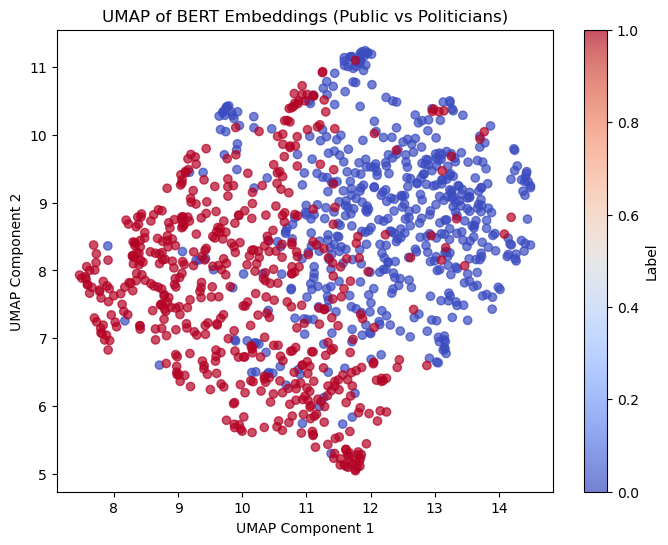

In [245]:
# Apply UMAP for dimensionality reduction to 2D
umap_2d = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap_2d.fit_transform(tweet_embeddings)

# Visualize the UMAP results
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=combined_tweets_df['label'], cmap='coolwarm', alpha=0.7)
plt.title('UMAP of BERT Embeddings (Public vs Politicians)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.colorbar(label='Label')
plt.show()

### Exploring citizen and politican tweet topics using BERTopic

In [246]:
# Separate DataFrames for citizens and politicians
citizen_tweets = combined_tweets_df[combined_tweets_df['label'] == 0]['text'].tolist()
politician_tweets = combined_tweets_df[combined_tweets_df['label'] == 1]['text'].tolist()

In [247]:
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.5, random_state=42)
vectorizer_model = CountVectorizer(stop_words="english")

citizen_model = BERTopic(umap_model=umap_model, vectorizer_model=vectorizer_model, min_topic_size=5, verbose=True)
citizen_topics, citizen_probs = citizen_model.fit_transform(citizen_tweets)

2024-10-13 18:11:48,736 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/18 [00:00<?, ?it/s]

2024-10-13 18:11:59,163 - BERTopic - Embedding - Completed ✓
2024-10-13 18:11:59,164 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-10-13 18:12:00,158 - BERTopic - Dimensionality - Completed ✓
2024-10-13 18:12:00,158 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-10-13 18:12:00,169 - BERTopic - Cluster - Completed ✓
2024-10-13 18:12:00,171 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-10-13 18:12:00,188 - BERTopic - Representation - Completed ✓


In [248]:
topic_info = citizen_model.get_topic_info()
print(topic_info.head())

   Topic  Count                              Name  \
0     -1     99  -1_politics_people_education_amp   
1      0    405    0_politics_news_political_vote   
2      1     23     1_ukraine_russia_war_politics   
3      2     11   2_podcast_episode_spreaker_link   
4      3      7   3_religion_pastors_politics_amp   

                                      Representation  \
0  [politics, people, education, amp, isnt, ameri...   
1  [politics, news, political, vote, democrats, r...   
2  [ukraine, russia, war, politics, putin, intern...   
3  [podcast, episode, spreaker, link, new, politi...   
4  [religion, pastors, politics, amp, getting, go...   

                                 Representative_Docs  
0  [Education is power &amp; politicians have dee...  
1  [Comment your opinion below… #netnews #news #t...  
2  [What Russia’s War means for the International...  
3  [📣 New Podcast! "Episode 3: Alderwoman Maria H...  
4  [what in the name of god #roe #roevwade #roevs...  


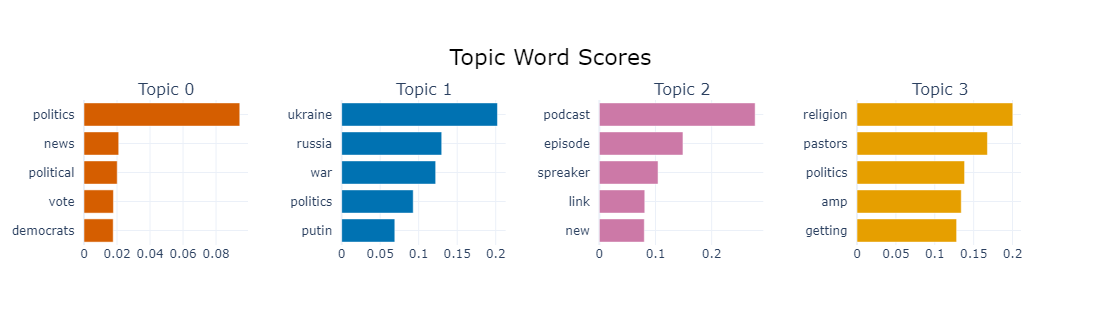

In [249]:
citizen_model.visualize_barchart(top_n_topics=10)

In [250]:
# For Citizen Topics
# Get topic information, skipping topic -1 (outliers)
citizen_topic_info = citizen_model.get_topic_info()
top_citizen_topics = citizen_topic_info[citizen_topic_info['Topic'] != -1].head(3)['Topic']

print("Top 3 Topics for Citizen Tweets:")
for topic in top_citizen_topics:
    print(f"\nTopic {topic} - {citizen_model.get_topic(topic)[0]}")
    representative_docs = citizen_model.get_representative_docs(topic)
    for i, doc in enumerate(representative_docs[:5]):  # Print top 5 representative tweets for each topic
        print(f"{i+1}: {doc}")

Top 3 Topics for Citizen Tweets:

Topic 0 - ('politics', 0.09437276689125289)
1: Comment your opinion below… #netnews #news #trending #share #follow #media #politics #trump #news #india #conservative #republican #usa #election #maga #america #memes https://t.co/xHWxFZAfFK
2: Why are you a democrat #Politics https://t.co/GNyXxAyJUR
3: Is it unfair for the #Senate to give only two people to each state? Short video here:

https://t.co/irT8WxPuSt

#news #politics #government #Congress #democrat #republican #democrats #republicans #conservative #liberal #GOP #Trump #MAGA #TrumpCult #DemocratsSaveLives

Topic 1 - ('ukraine', 0.20227292870591204)
1: What Russia’s War means for the International Space Station
International Space Station The International Space Station has been orbiting above us for the last 20 years. It’s been home[…] #Ukraine #Space #tech #Politics #geopolitics 

Full Story :  https://t.co/jBRo6uOzJf https://t.co/mku4yWsXUQ
2: @JoeBiden Who else knows about the future war bet

In [251]:
politician_model = BERTopic(umap_model=umap_model, vectorizer_model=vectorizer_model, min_topic_size=5, verbose=True)
politician_topics, politician_probs = politician_model.fit_transform(politician_tweets)

2024-10-13 18:12:00,247 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/18 [00:00<?, ?it/s]

2024-10-13 18:12:07,665 - BERTopic - Embedding - Completed ✓
2024-10-13 18:12:07,665 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-10-13 18:12:08,649 - BERTopic - Dimensionality - Completed ✓
2024-10-13 18:12:08,649 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-10-13 18:12:08,658 - BERTopic - Cluster - Completed ✓
2024-10-13 18:12:08,659 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-10-13 18:12:08,678 - BERTopic - Representation - Completed ✓


In [252]:
topic_info = politician_model.get_topic_info()
print(topic_info.head())

   Topic  Count                                   Name  \
0     -1    314                  -1_amp_today_rt_great   
1      0     35        0_rt_nomination_scotus_housegop   
2      1     31  1_repthomasmassie_rt_questions_chavez   
3      2     26       2_rt_hearing_natresources_animal   
4      3     17        3_aca_care_obamacare_healthcare   

                                      Representation  \
0  [amp, today, rt, great, jobs, veterans, new, h...   
1  [rt, nomination, scotus, housegop, senategops,...   
2  [repthomasmassie, rt, questions, chavez, vp, v...   
3  [rt, hearing, natresources, animal, case, cae,...   
4  [aca, care, obamacare, healthcare, medicaid, p...   

                                 Representative_Docs  
0  [Join me tmrw 1:30 PM at Comsewogue High Schoo...  
1  [RT @DailyReport: Leahy Tells NY Times Boggs' ...  
2  [RT @CAPAC: .@CAPAC Chair @RepJudyChu w/Paul &...  
3  [TODAY at 10 am ET: Hearing on Trump Treasury ...  
4  [RT @janschakowsky: Medicaid rationi

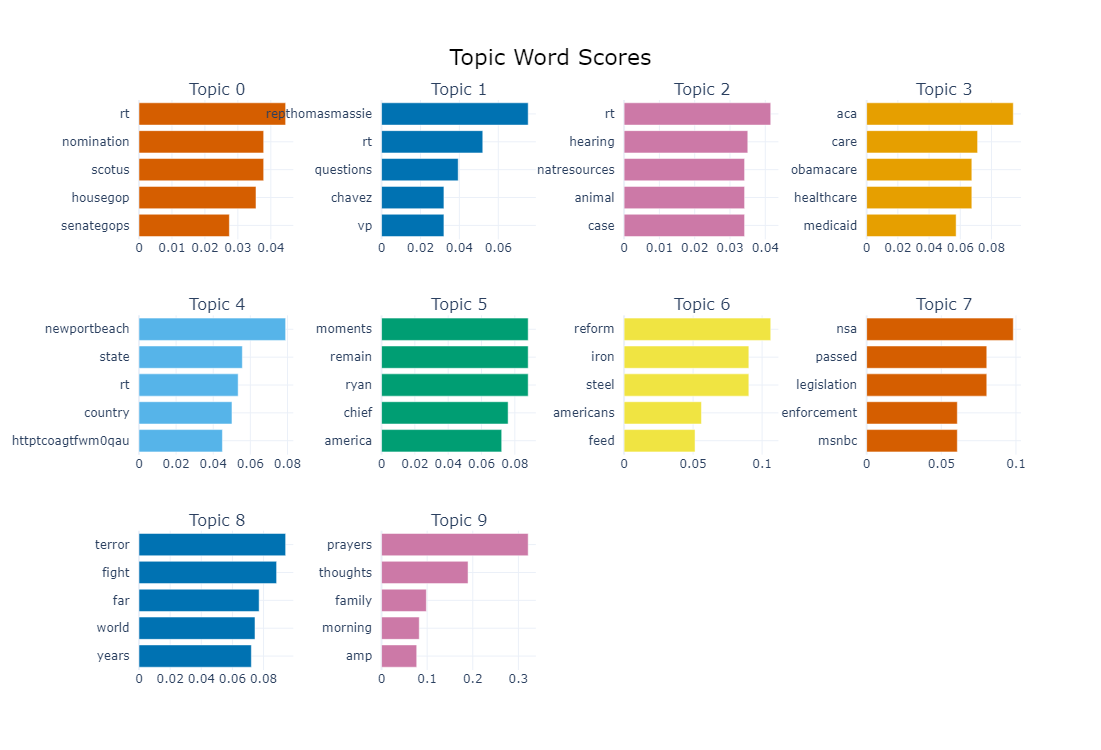

In [253]:
politician_model.visualize_barchart(top_n_topics=10)

In [254]:
# For Politician Topics
# Get topic information, skipping topic -1 (outliers)
politician_topic_info = politician_model.get_topic_info()
top_politician_topics = politician_topic_info[politician_topic_info['Topic'] != -1].head(3)['Topic']

print("\nTop 3 Topics for Politician Tweets:")
for topic in top_politician_topics:
    print(f"\nTopic {topic} - {politician_model.get_topic(topic)[0]}")
    representative_docs = politician_model.get_representative_docs(topic)
    for i, doc in enumerate(representative_docs[:5]):  # Print top 5 representative tweets for each topic
        print(f"{i+1}: {doc}")


Top 3 Topics for Politician Tweets:

Topic 0 - ('rt', 0.044492589469500896)
1: RT @DailyReport: Leahy Tells NY Times Boggs' Nomination Dead: http://t.co/HD7vbzdAy1  #federaljudiciary @GACourts
2: RT @westgov: Speech: @GovMaryFallin signed Oklahoma Water for 2060 Act to "establish an aggressive goal for water conservation in our state…
3: RT @realDonaldTrump: Hope you like my nomination of Judge Neil Gorsuch for the United States Supreme Court. He is a good and brilliant man,…

Topic 1 - ('repthomasmassie', 0.07537045941324585)
1: RT @CAPAC: .@CAPAC Chair @RepJudyChu w/Paul &amp; Christine Chavez honoring the life &amp; legacy of Cesar Chavez #CHCI http://t.co/F1DP0IGs6h
2: RT @PhiladelphiaGov: Mayor Kenney will answer your questions this Friday during the first admin twitter chat! Tweet your questions now usin…
3: RT @repjustinamash: #ff @RepThomasMassie @RepThomasMassie @RepThomasMassie @RepThomasMassie @RepThomasMassie @RepThomasMassie @RepThomas ...

Topic 2 - ('rt', 0.041541550372

### Using LLM (OpenAI) with LangChain to summarise top three topics of topic model

In [255]:
# Initialize the chat-based model
llm = ChatOpenAI(model_name="gpt-3.5-turbo")

# Define the prompt template with SystemMessage and HumanMessage prompt templates
prompt_template = ChatPromptTemplate(
    input_variables=["tweets"],
    messages=[
        SystemMessagePromptTemplate.from_template("You are a helpful assistant that summarizes the major themes of tweets into broad topic summaries."),
        HumanMessagePromptTemplate.from_template("Summarize the following tweets into a coherent topic summary, describing the general themes of the tweets:\n\n{tweets}\n\nSummary:")
    ]
)

In [256]:
# Function to summarize the top three topics using ChatOpenAI
def summarize_top_topics(model, top_topics, num_representative_docs=5):
    summaries = {}
    for topic in top_topics:
        # Get representative tweets for the topic
        representative_docs = model.get_representative_docs(topic)[:num_representative_docs]
        
        # Join tweets into a single string for summarization
        tweets_text = "\n".join(representative_docs)
        
        # Generate summary using ChatOpenAI
        response = llm(prompt_template.format(tweets=tweets_text))
        summary = response.content  # Extract the summary content
        summaries[topic] = summary
        print(f"Topic {topic} Summary:\n{summary}\n")  # Print only the content
    


In [257]:
# Get the topic information from the citizen model
citizen_topic_info = citizen_model.get_topic_info()

# Get the top three topics, excluding outliers
top_citizen_topics = citizen_topic_info[citizen_topic_info['Topic'] != -1].head(3)['Topic']

# Generate summaries for the Citizen Topics
citizen_summaries = summarize_top_topics(citizen_model, top_citizen_topics)

Topic 0 Summary:
The general theme of the tweets is centered around politics, particularly discussing topics such as the Senate representation, political parties, and the current administration. There is also mention of news, media, and the impact of political decisions on various groups. The tweets reflect a mix of conservative and liberal viewpoints, as well as opinions on the current political climate in the USA.

Topic 1 Summary:
The general theme of the tweets is the impact of Russia's war on the International Space Station. There is discussion about the potential consequences of the conflict between Russia and Ukraine, with mentions of geopolitics, politics, and the role of various countries such as the USA, NATO, and China. The tweets also touch on concerns about the future of Ukraine, as well as the potential for military conflict and the implications for oil and gas politics.

Topic 2 Summary:
The general theme of the tweets is podcasts discussing various political topics and 

In [258]:
# Get the topic information from the citizen model
politician_topic_info = politician_model.get_topic_info()

# Get the top three topics, excluding outliers
top_politician_topics = politician_topic_info[politician_topic_info['Topic'] != -1].head(3)['Topic']

# Generate summaries for the Citizen Topics
politician_summaries = summarize_top_topics(politician_model, top_citizen_topics)

Topic 0 Summary:
The tweets discuss various nominations and appointments in the federal judiciary, including the nomination of Judge Neil Gorsuch to the United States Supreme Court and the status of Boggs' nomination. There is also mention of a water conservation act signed by Governor Mary Fallin in Oklahoma. The overall theme is related to government appointments and policies in the legal and environmental sectors.

Topic 1 Summary:
The tweets cover a range of topics including honoring the legacy of Cesar Chavez, a Twitter chat with Mayor Kenney, and a series of mentions of Representative Thomas Massie.

Topic 2 Summary:
The tweets discuss various government-related events, including a hearing on Trump's Treasury nominee Steven Mnuchin, a thank you message to Tom Rooney for blocking new regulations, and the launch of a review of juvenile justice in West Virginia by Governor Tomblin and the Intergovernmental Taskforce on Juvenile Justice.



### Building and evaluating a range of classifier models

In [259]:
# SSplit the UMAP-reduced data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_umap, combined_tweets_df['label'], test_size=0.2, random_state=42)

In [260]:

# Define classifiers to evaluate
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier()
}

In [261]:
# Train and evaluate each classifier on the UMAP-reduced data
results = {}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_probs = clf.predict_proba(X_test)[:, 1]  # Probability of class 1 for AUC-ROC

    # Calculate metrics
    auc_score = roc_auc_score(y_test, y_pred_probs)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    # Save results
    results[name] = {
        "AUC-ROC": auc_score,
        "Accuracy": accuracy,
        "Confusion Matrix": conf_matrix,
        "Classification Report": class_report
    }
    
    # Print results
    print(f"--- {name} ---")
    print(f"AUC-ROC Score: {auc_score:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    print("\n")

# Summary of AUC-ROC scores for comparison
print("Summary of AUC-ROC Scores:", {name: results[name]["AUC-ROC"] for name in results})

--- Logistic Regression ---
AUC-ROC Score: 0.8993
Accuracy: 0.8257
Confusion Matrix:
[[93 23]
 [15 87]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       116
           1       0.79      0.85      0.82       102

    accuracy                           0.83       218
   macro avg       0.83      0.83      0.83       218
weighted avg       0.83      0.83      0.83       218



--- SVM ---
AUC-ROC Score: 0.9009
Accuracy: 0.8440
Confusion Matrix:
[[95 21]
 [13 89]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       116
           1       0.81      0.87      0.84       102

    accuracy                           0.84       218
   macro avg       0.84      0.85      0.84       218
weighted avg       0.85      0.84      0.84       218



--- Random Forest ---
AUC-ROC Score: 0.9160
Accuracy: 0.8578
Confusion Matrix:
[[99 17]
 [14 88]]
Classi

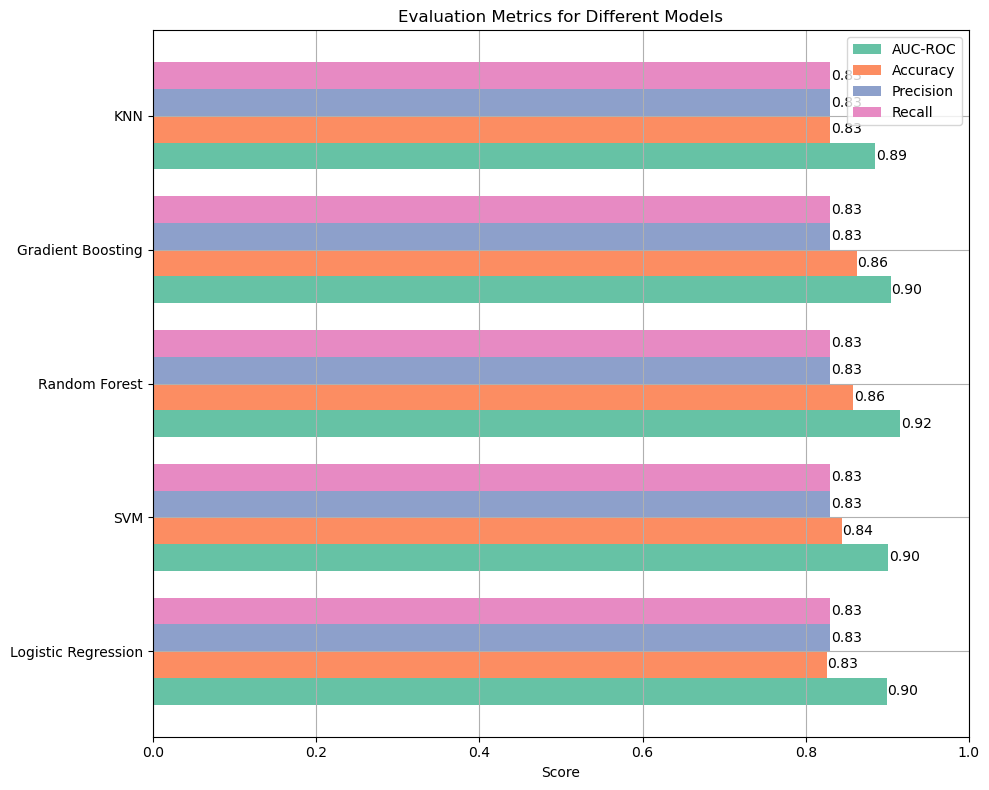

In [262]:
# Define a color palette
colors = sns.color_palette("Set2", 4)  # Choose "Set2" or any other palette you prefer

# Prepare data for plotting
metrics = ["AUC-ROC", "Accuracy", "Precision", "Recall"]
models = list(results.keys())

# Initialize lists for each metric
auc_scores = []
accuracies = []
precisions = []
recalls = []

# Extract metrics for each model
for model in models:
    auc_scores.append(results[model]["AUC-ROC"])
    accuracies.append(results[model]["Accuracy"])
    
    # Using y_pred from stored results instead of confusion matrix
    y_pred = clf.predict(X_test)
    
    # Generate classification report as dictionary to get precision and recall
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    
    precisions.append(report_dict["weighted avg"]["precision"])
    recalls.append(report_dict["weighted avg"]["recall"])

# Define figure
fig, ax = plt.subplots(figsize=(10, 8))

# Set bar width
bar_width = 0.2

# Define positions for each set of bars
x = np.arange(len(models))

# Plot bars for each metric with the selected color palette
bars1 = ax.barh(x - 1.5 * bar_width, auc_scores, height=bar_width, label="AUC-ROC", color=colors[0])
bars2 = ax.barh(x - 0.5 * bar_width, accuracies, height=bar_width, label="Accuracy", color=colors[1])
bars3 = ax.barh(x + 0.5 * bar_width, precisions, height=bar_width, label="Precision", color=colors[2])
bars4 = ax.barh(x + 1.5 * bar_width, recalls, height=bar_width, label="Recall", color=colors[3])

# Add the values at the end of each bar
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        ax.text(
            bar.get_width() + 0.02,   # X-coordinate
            bar.get_y() + bar.get_height()/2,   # Y-coordinate
            f"{bar.get_width():.2f}",  # Text
            ha='center', va='center'
        )


# Customize plot
ax.set_xlabel("Score")
ax.set_yticks(x)
ax.set_yticklabels(models)
ax.set_title("Evaluation Metrics for Different Models")
ax.legend()
plt.xlim(0, 1)
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

It looks like Gradient Boosting has emerged as the top-performing classifier in terms of both AUC-ROC score (0.9135) and accuracy (0.8394). This suggests that Gradient Boosting is well-suited for distinguishing between citizen and politician tweets based on the UMAP-reduced features.

Here's a summary of the results:

Gradient Boosting: Highest AUC-ROC score at 0.9135, with an accuracy of 0.8394. It performed particularly well in capturing the trade-off between sensitivity (recall) and specificity (precision), yielding balanced performance.

Random Forest and Logistic Regression: Both achieved strong AUC-ROC scores just above 0.90, with Random Forest edging slightly higher. However, their accuracy and other metrics were slightly lower than Gradient Boosting.

SVM: Achieved a competitive AUC-ROC score of 0.8955 with a slightly lower accuracy of 0.8303, indicating a solid overall performance. It demonstrated high precision for both classes, though slightly lower recall than Gradient Boosting.

KNN: Although it has the lowest AUC-ROC score at 0.8420, it still provided acceptable results with an accuracy of 0.7661. This is typical for KNN, which may struggle with higher-dimensional data after UMAP reduction compared to other algorithms.

### Fine tuning the GBM model with GridSearchCV and evaluating model using cross-validation

In [263]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

# Initialize Gradient Boosting model
gbm = GradientBoostingClassifier(random_state=42)

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(gbm, param_grid, scoring='roc_auc', cv=5, verbose=1)
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding AUC-ROC score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validated AUC-ROC Score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 150}
Best Cross-Validated AUC-ROC Score: 0.9217


In [264]:
# Cross-validation using the best estimator
best_gbm = grid_search.best_estimator_
cv_scores = cross_val_score(best_gbm, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Cross-Validated AUC-ROC Scores: {cv_scores}")
print(f"Mean AUC-ROC: {cv_scores.mean():.4f}")

Cross-Validated AUC-ROC Scores: [0.90945911 0.913052   0.92524785 0.93875529 0.9221723 ]
Mean AUC-ROC: 0.9217


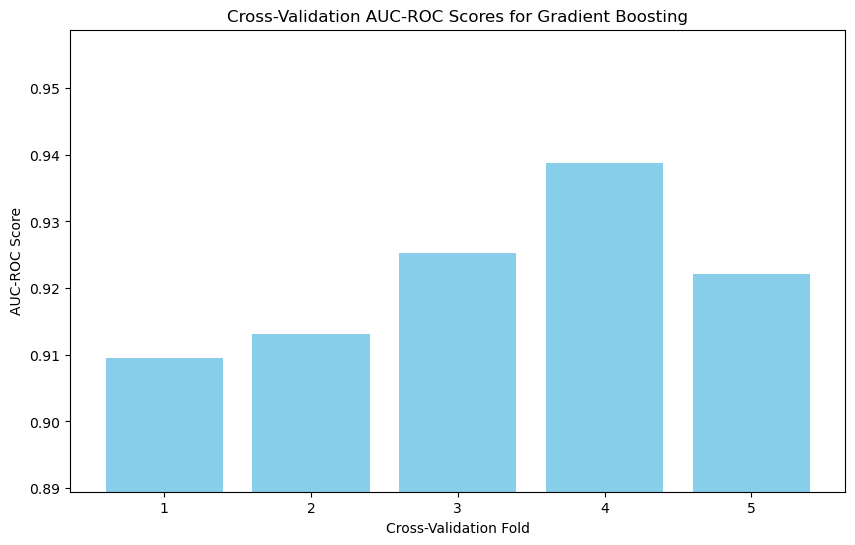

In [265]:
# Plotting the bar chart using the cv_scores
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(cv_scores) + 1), cv_scores, color='skyblue')
plt.xlabel('Cross-Validation Fold')
plt.ylabel('AUC-ROC Score')
plt.title('Cross-Validation AUC-ROC Scores for Gradient Boosting')
plt.ylim(min(cv_scores) - 0.02, max(cv_scores) + 0.02)  # Set y-axis slightly beyond min/max for better visualization
plt.xticks(range(1, len(cv_scores) + 1))
plt.show()

### Using our fine-tuned GBM model to predict classification (citizen vs. politician) of a Tweet.

In [266]:
# Function to classify a new tweet
def classify_tweet(tweet_text):
    """
    Classify a tweet as either 'politician' or 'citizen' and provide model confidence.
    
    Parameters:
        tweet_text (str): The tweet text input by the user.
    
    Returns:
        str: Predicted label (Citizen or Politician) with confidence score.
    """
    # Encode the tweet using the pre-trained BERT model
    tweet_embedding = transformer_model.encode([tweet_text])
    
    # Apply the trained UMAP model for dimensionality reduction
    tweet_umap = umap_model.transform(tweet_embedding)
    
    # Predict the class label and confidence using the trained classifier
    pred_prob = best_gbm.predict_proba(tweet_umap)
    pred_label = best_gbm.predict(tweet_umap)[0]
    pred_confidence = pred_prob[0][pred_label]
    label_name = "Politician" if pred_label == 1 else "Citizen"
    
    # Print the result
    print(f"Predicted as: {label_name} with {pred_confidence * 100:.2f}% confidence.")
    
    return label_name, pred_confidence

In [267]:
# Example usage
tweet_text = input("Enter a tweet: ")
label, confidence = classify_tweet(tweet_text)

Enter a tweet:  We can do better as a society, we can make the tough decisions and work towards a better future


Predicted as: Politician with 86.46% confidence.
